In [2]:
import gzip
from itertools import islice
from graph_yq import DeBrujinGraph

In [3]:
def read_fastq(path):
    with gzip.open(path, 'rt') as f:
        for line in f:
            seqid, description = line[1:].rstrip().split(maxsplit=1)
            sequence = f.readline().rstrip()
            _ = f.readline()
            quality = f.readline().rstrip()
            yield seqid, description, sequence, quality

In [4]:
k = 21
kmers = []

In [5]:
%%time
for _, _, seq, _ in read_fastq('reads.fastq.gz'):
    kmers.extend([seq[i:i+k] for i in range(len(seq) - k + 1)])

CPU times: user 1.6 s, sys: 156 ms, total: 1.75 s
Wall time: 1.76 s


In [6]:
%%time
length = min(10000, len(kmers))
graph = DeBrujinGraph(nodes = kmers[:length], k = 21)

CPU times: user 4.45 s, sys: 7.58 ms, total: 4.45 s
Wall time: 4.47 s


In [7]:
print("node counts:", graph.node_count())
print("edge counts:", graph.edge_count(), graph._edge_num)

node counts: 10000
in couting edges methods
edge counts: 9875 9875


## Question 3 Parcour

In [8]:
def DFS( g, u, discovered ):
    """deep first search of a graph.
    params
        g: a graph
        u: a node of graph g
        discovered: a dictionary marking where a edge is visited
    return
        None, discovered modified
    """
    for v in g.successors( u ):
        if v not in discovered:
            discovered[v] = u # u represents parent node of v
                              # v carries the edge information v[-1]
            DFS( g, v, discovered )
            
            
def build_fragment( g, u, v, discovered ):
    """build a fragment from node u to v based on the discovered paths in graph
    params
        g: graph
        u: start node of a fragment, str
        v: end node of a fragment, str
        discovered: dictionary from a deep first search of a graph g
    returns
        fragment: str
    """
    frag = []
    if v in discovered:
        walk = v
        while walk is not u:
            parent = discovered[walk]
            frag.append(walk[-1])
            walk = parent
        # walk is now u
        
    frag.reverse()
    frag = u + "".join(frag)
    return frag

In [9]:
# find the nodes who have no predecessors
def find_nodes(g, has_no_predecessors = True):
    """find all nodes without predecessors or without successors controled by
    a bool parameter
    params
        g: graph
        has_no_predecessors: bool, if True, find all nodes without predecessors,
            If False, find all nodes without successors
    returns
        results, list of nodes
    """
    results = []
    for node in g.nodes():
        func = g.predecessors
        if has_no_predecessors == False:
            func = g.successors
        if len(func(node)) == 0: # no predecessors
            results.append(node)
    return results           

In [10]:
%%time
nodes_without_predecessors = find_nodes(graph)
nodes_without_successors = find_nodes(graph, False)

CPU times: user 4.42 s, sys: 0 ns, total: 4.42 s
Wall time: 4.42 s


In [11]:
print(nodes_without_predecessors)
print(len(nodes_without_predecessors))

['CCAGCTCTTGAATCATCTGCG', 'ATGTGATGAATGTGATCGGCG', 'GCTGCTGCTTGCGTCTTGGGT', 'GTGAAGTTGAGAGGAGGAGAT', 'TGAAGAGGAGATGAGAAGCGG', 'AGAACCATTCTCGGAGGACAT', 'CCGAAGACCCCTCCCACTTTA', 'GCAGCTTGTTTCCTGTCAACA', 'TTGCAAAGACTACGCGGCTCG', 'ATTCCAAGAAGGTGATGAACT', 'AAATGTGGTTCTTCCAAATGG', 'GCCTCACTCCTCAACAAAGTC', 'ATATCATATCCGATCTGTTGA', 'GCTTCTTGATACAGTTCAGAT', 'TCTGGAGATATCTTCATCAGG', 'ATTGCTGCATTTTGGCCTCAA', 'GTTAGCACTTGGAAGACAATT', 'ACAGATTCATCAACACAAACT', 'ACTTGTCTACACGAAAACCTT', 'GATCTCGAAGCAGGCAGAAAT', 'CTTGCCGCCAATTTGCAACGA', 'GCTTTTCCGTTTAAATGTGCA', 'AAAGCCGATCTACTTGAAGAC', 'GTGTCATCATTCCTTCTCATG', 'GATGAAATGGAGCTGAAAAAG', 'TGCCTGTCGAACAGAATGGGA', 'AAGTCACGAATTGGCCCGTAC', 'ATTCCGAGGAACCAGAAGCAG', 'TCGGAATGTATCTCGTGATTT', 'CGTTGAGAGATTTGGTGGCTG', 'TATTCTATCCGTGTGTTCTTC', 'TGGGTACGGAAGCTATGGTGG', 'CGTTGAAGACGAAATTGTCAA', 'AACGTCATCATCGACGGAAGG', 'GATTTTAAAACTGAATATATG', 'AAATCCGACACATCAATTTGC', 'TGCAGCCTACGAAATGACTCC', 'GTCACAATAGAAGAGGAGAAG', 'AGCTCCCAGAAGTTGCAAGAG', 'ATTCCTTGACGCTTTCAACTT',

In [12]:
print(nodes_without_successors)
print(len(nodes_without_successors))

['GAAACTCTGCTCACGGGCGAT', 'TTCGAACACAAACTTCATTAC', 'AGGGCCTCATACAGTTAACAT', 'ATTTGGAATTCTAATCGGTAT', 'CTTCGAAATCTTTCGGGGCCA', 'AACAAATCAAGACTTTAATGA', 'TCCGATTTGCAGTTGGAGAGA', 'TGAAAGTGTATCAGAAGAAAG', 'ATTCGGATGTGGCTATCGTAG', 'TGATGGATGAAGTTATTCGAG', 'TTGGGAGAATGGACTATCATT', 'AAGTATACACATGTCCGAGGG', 'TTGGTCAAGAAGCCACGTATC', 'AGATTACTTCCCATCAAATTC', 'CAAGTGGTTGTTTCAAAATAG', 'GAGAAACGTCGGATTGGCTTC', 'GTTGGAGGAAGAAGGAGAAGA', 'TCCGAAAACCAAACAGCACAG', 'GGAAGTCAAAGGAAGATGGCA', 'ACAAGACAAACACGTGCTCCA', 'AAGACCCCGACAATGTGAAAG', 'AAATCGACGATTTAATTGGAG', 'TCAATCCATATGTGCTAAGCC', 'AGTTAAACACCCAAAAATGGT', 'AAAGGATAAAATGTTGTTAGT', 'TTCATGCTCAGTTGATGAAAG', 'GCCTACAGTTTTTATGGAAAA', 'GGGACTACGGCGACTAATAAA', 'CGGCGAAATCACAAATTCTGC', 'CAAGGCAGAGCCAGTACTTGG', 'TGCCACGTGTCAAAGTGATCG', 'GAATTTCATGGTAGCAATGAA', 'CTCACTGCTGAAGAAACACCT', 'TGAGCATCGGTTGTGCCGTCG', 'AAGCCAGGGATCAACAGAAAT', 'GATGACGAGACAGATCAAGAA', 'AGTGCCTTGGAATCCGATCAT', 'AAGGAGATGTATGTTTTATTG', 'CAGAGACACGTCATTAGTGGT', 'TTGTCGAAGGAATGCCAGCAT',

In [13]:
fragments = []
for origin_node in nodes_without_predecessors:
    discovered = {origin_node: '-'}
    DFS(graph, origin_node, discovered)
    for dest_node in nodes_without_successors:
        if discovered.get(dest_node, None) is not None:
            fragment = build_fragment(graph, origin_node, dest_node, discovered)
            fragments.append(fragment)

In [14]:
print(len(fragments))

125


In [15]:
print(fragments[1])

ATGTGATGAATGTGATCGGCGAGGCAAAACAACTGTTGGCATCCAGCCCAACACCTGCAACGTTCTTCGGCATCTATTACGATAACCCAGAAGTCACCGA


In [69]:
# Test

seq = "ATGTGATGAATGTGATCGGCGAGGCAAAACAAC"
k = 5
kmers = [seq[i:i+k] for i in range(len(seq) - k + 1)]
print("seq: ", seq)
print("kmers: ", kmers)

print("initialize graph with kmers and k")
graph2 = DeBrujinGraph(kmers, k = k)
print(graph2)

seq:  ATGTGATGAATGTGATCGGCGAGGCAAAACAAC
kmers:  ['ATGTG', 'TGTGA', 'GTGAT', 'TGATG', 'GATGA', 'ATGAA', 'TGAAT', 'GAATG', 'AATGT', 'ATGTG', 'TGTGA', 'GTGAT', 'TGATC', 'GATCG', 'ATCGG', 'TCGGC', 'CGGCG', 'GGCGA', 'GCGAG', 'CGAGG', 'GAGGC', 'AGGCA', 'GGCAA', 'GCAAA', 'CAAAA', 'AAAAC', 'AAACA', 'AACAA', 'ACAAC']
initialize graph with kmers and k
in couting edges methods
G( 26 nodes{ GAGGC CGGCG AATGT GCAAA ATGAA AAACA GATCG TGAAT TGATC GAATG ATGTG GGCAA CAAAA GATGA TGATG AGGCA TCGGC CGAGG GGCGA TGTGA ACAAC ATCGG GTGAT AAAAC AACAA GCGAG }, 26 edges{ ('GAGGC', 'AGGCA') ('CGGCG', 'GGCGA') ('AATGT', 'ATGTG') ('GCAAA', 'CAAAA') ('ATGAA', 'TGAAT') ('AAACA', 'AACAA') ('GATCG', 'ATCGG') ('TGAAT', 'GAATG') ('TGATC', 'GATCG') ('GAATG', 'AATGT') ('ATGTG', 'TGTGA') ('GGCAA', 'GCAAA') ('CAAAA', 'AAAAC') ('GATGA', 'ATGAA') ('TGATG', 'GATGA') ('AGGCA', 'GGCAA') ('TCGGC', 'CGGCG') ('CGAGG', 'GAGGC') ('GGCGA', 'GCGAG') ('TGTGA', 'GTGAT') ('ATCGG', 'TCGGC') ('GTGAT', 'TGATC') ('GTGAT', 'TGATG') ('AAAAC', 'A

In [70]:
start_nodes = find_nodes(graph2)
end_nodes = find_nodes(graph2, False)

In [71]:
print(start_nodes)
print(end_nodes)

[]
['ACAAC']


In [72]:
def read_fasta(path):
    with gzip.open(path, 'rt') as f:
        accession, description, seq = None, None, None
        for line in f:
            if line[0] == '>':
                # yield current record
                if accession is not None:
                    yield accession, description, seq
                    
                # start a new record
                accession, description = line[1:].rstrip().split(maxsplit=1)
                seq = ''
            else:
                seq += line.rstrip()

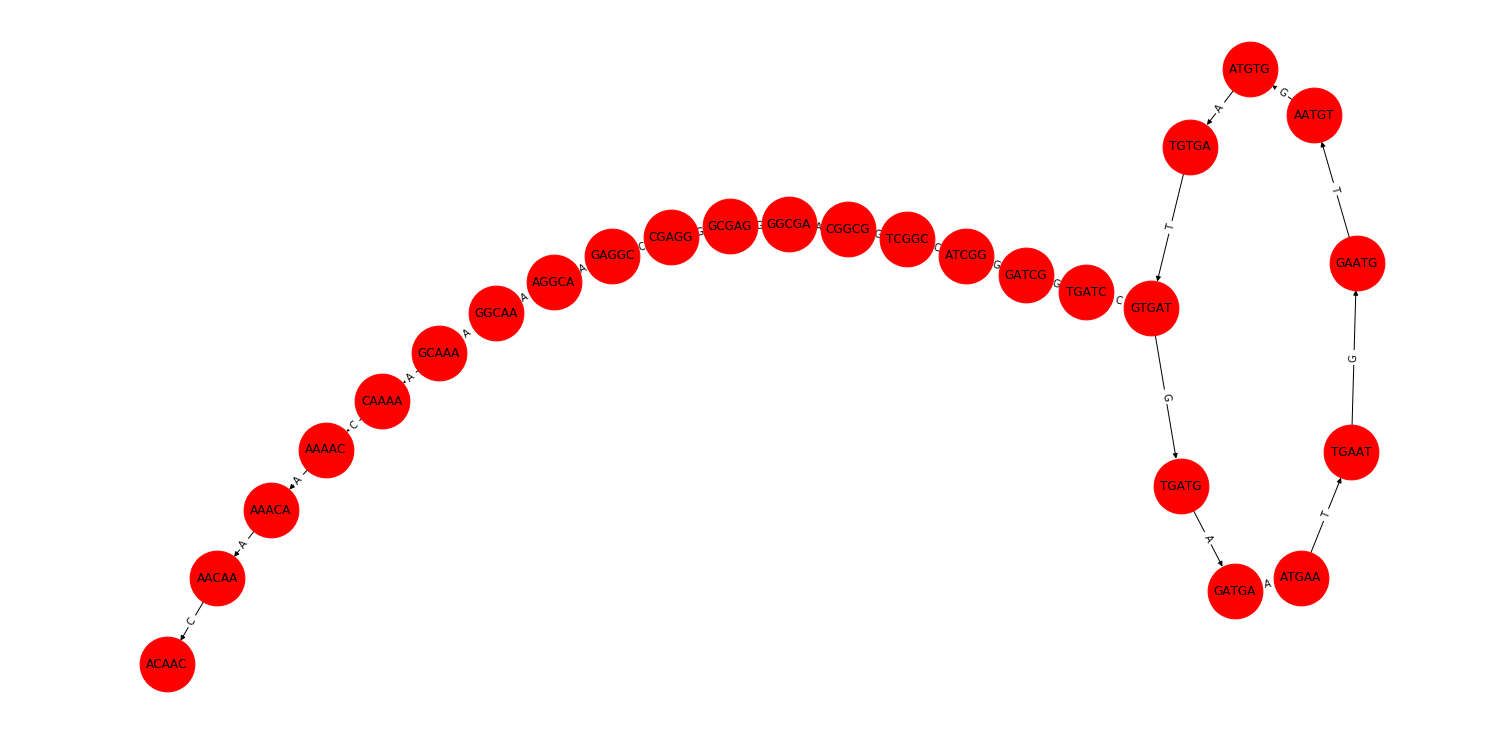

In [73]:
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt

def edges(kmers_graph):
    for k in kmers_graph:
        for s in 'ATCG':
            successor = k[1:] + s
            if successor in kmers_graph:
                yield k, successor


plt.figure(figsize=(20,10))
g = nx.DiGraph()
g.add_nodes_from(graph2)
g.add_edges_from((u, v, {'label': v[-1]}) for u, v in edges(graph2))
nx.draw(g, pos=nx.drawing.nx_agraph.graphviz_layout(g), with_labels=True, node_size=3000)
nx.draw_networkx_edge_labels(g, pos=nx.drawing.nx_agraph.graphviz_layout(g), edge_labels=nx.get_edge_attributes(g, 'label'))
plt.show()